In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
import time
from contextlib import contextmanager

@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        print(f"Elapsed time: {end_time - start_time:.4f} seconds")
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True)
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]
def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example
def process_sft_dataset(dataset_name, dataset, dataset_sample=None)->datasets.Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = datasets.Dataset.from_pandas(df)
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']:       # TODO: 'lavita/ChatDoctor-HealthCareMagic-100k'. not sure whether to discard the instruction.
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=2023)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset
processed_data = []
for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca","TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,general_data,math_data]):
# for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards", "TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,math_data]):
    tmp:datasets.Dataset = process_sft_dataset(name,dataset)
    print(tmp.column_names)
    processed_data.append(tmp)

----------using 8*GPUs----------
>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====
['response', 'instruction', '__index_level_0__']


In [2]:
def labeling(example, label):
    example["label"] = label
    return example
label = ["code","fin","med", "gen", "math"]

for i, data in enumerate(processed_data):
    data = data.map(lambda example: labeling(example, label[i]), batched=False)
    processed_data[i] = data

Map:   0%|          | 0/224567 [00:00<?, ? examples/s]

In [2]:
# data_concated: Dataset = concatenate_datasets(processed_data)
data_concated: Dataset = processed_data[0]

In [3]:
iid_idxs = random.sample(range(len(data_concated)), 1000)
base_data = data_concated.select(iid_idxs)
clients_data = []
for i in range(10):
    clients_data.append(base_data.shard(10,i))

data_concated = data_concated.select(list(set(range(len(data_concated)))-set(iid_idxs)))
print(len(data_concated))

19022


# 对0号客户端进行聚类

In [4]:
k=10
from sklearn.cluster import MiniBatchKMeans, KMeans
base_0_embeddings = model.encode(clients_data[0]["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = KMeans(n_clusters=k, random_state=0).fit(base_0_embeddings)
labels = kmeans.labels_
# 计算每个簇的样本数量
counts = np.bincount(labels)
# 找到最大的簇的标签
largest_cluster_label = np.argmax(counts)
# 从 cluster_centers_ 中获取最大的簇的中心
cluster_center_0:np.array = kmeans.cluster_centers_[largest_cluster_label]
print(cluster_center_0.shape)

(1024,)


In [5]:
client_clusters = cluster_center_0.reshape((1,1024))

In [6]:
print(kmeans.cluster_centers_.shape)

(10, 1024)


In [7]:
for i in range(10-1):
    i=i+1
    base_i_embeddings = model.encode(clients_data[i]["instruction"])
    # 假设 embeddings 是你的嵌入数据
    kmeans = KMeans(n_clusters=k, random_state=0).fit(base_i_embeddings)
    labels = kmeans.labels_
    similarity_scores = np.sum(kmeans.cluster_centers_ @ client_clusters.T, axis=-1)
    print(similarity_scores.shape)
    selected_idxs = np.argsort(similarity_scores)[i:]
    # 计算每个簇的样本数量
    counts = np.bincount(labels)
    # 找到最大的簇的标签
    largest_cluster_labels = np.argsort(-counts) #降序
    largest_cluster_label = -1
    for i in largest_cluster_labels:
        if i in selected_idxs:
            largest_cluster_label = i
    # 从 cluster_centers_ 中获取最大的簇的中心
    largest_cluster_center = kmeans.cluster_centers_[largest_cluster_label]
    client_clusters = np.concatenate([client_clusters,largest_cluster_center.reshape((1,1024))])

(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


/home/tiger/.local/lib/python3.9/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


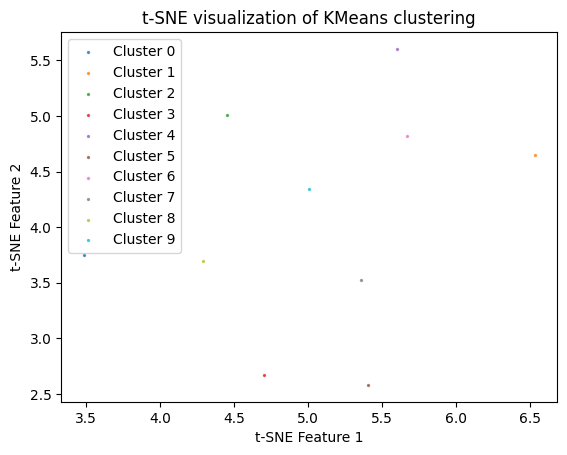

In [8]:
labels = np.array([i for i in range(10)])
# 使用 t-SNE 进行降维
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(client_clusters)
# 可视化聚类结果
plt.figure()
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# 将 data_concated 恢复为 public_data

In [17]:
data_concated: Dataset = concatenate_datasets(processed_data)
data_concated = data_concated.select(list(set(range(len(data_concated)))-set(iid_idxs)))
print(len(data_concated))

406318


In [18]:
concated_embeddings = model.encode(data_concated["instruction"])
concated_embeddings = torch.tensor(concated_embeddings, dtype=torch.float32)
client_clusters = torch.tensor(client_clusters, dtype=torch.float32)

Inference Embeddings: 100%|██████████| 199/199 [02:29<00:00,  1.33it/s]
/tmp/ipykernel_1206748/1939527034.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  client_clusters = torch.tensor(client_clusters, dtype=torch.float32)


In [19]:
import numpy as np
import random
random.seed(10)
client_pos_datasets = []
for i, sampled_data in enumerate(clients_data):
    print(i)
    similarity_scores = torch.matmul(client_clusters[i,:].cuda(), (concated_embeddings.T).cuda()).cpu()
    top_idxs = heapq.nlargest(1500, range(len(similarity_scores)-1), key=lambda x: similarity_scores[x])
    pos_datasets: Dataset = []
    pos_datasets = data_concated.select(top_idxs)
    pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
    pos_datasets = pos_datasets.shuffle(seed=42)
    client_pos_datasets.append(pos_datasets)

0
1
2
3
4
5
6
7
8
9


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
/home/tiger/.local/lib/python3.9/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


<Figure size 640x480 with 0 Axes>

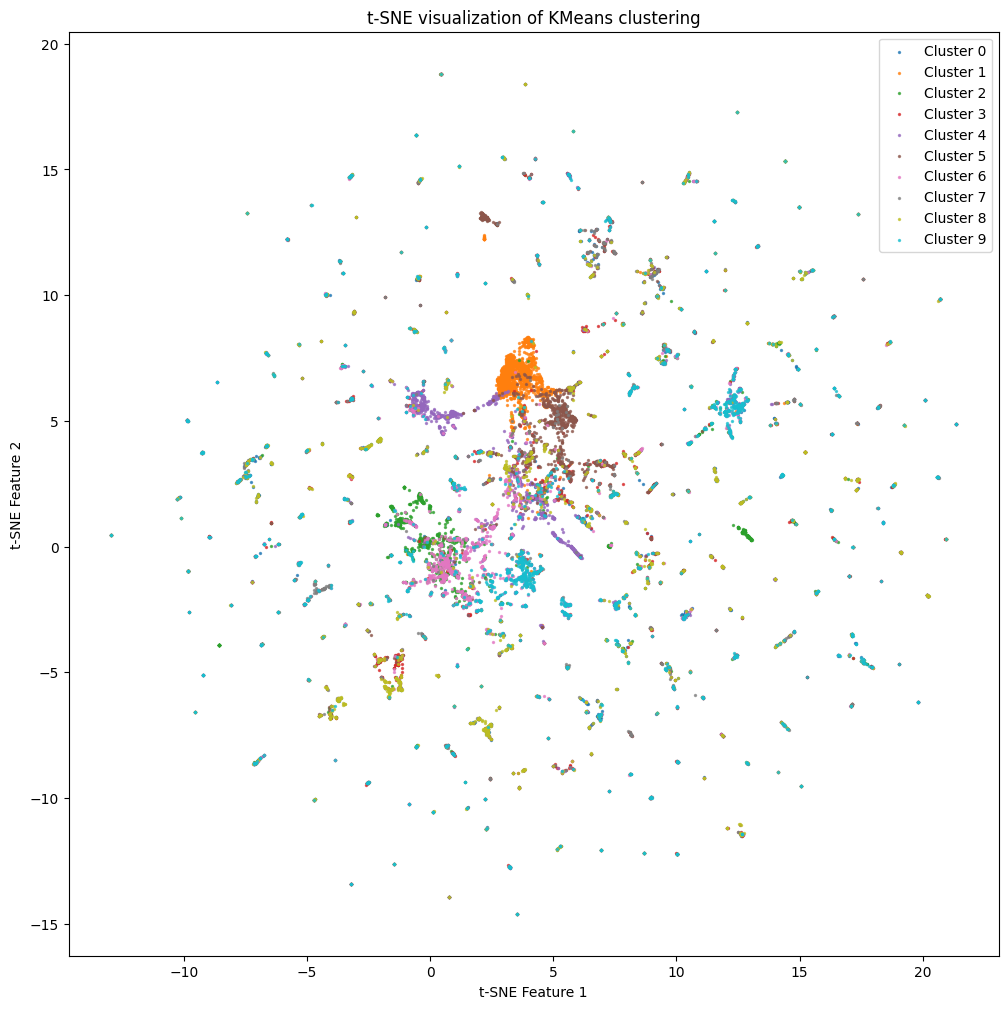

In [20]:
# 遍历数据并进行 t-SNE 可视化
embeddings = []
labels = []
for i, data in enumerate(client_pos_datasets):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

In [21]:
for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/iid2niid_code_public_{i}.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]